In [1]:
import climt
import numpy as np
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
from scipy.interpolate import interp2d, RectBivariateSpline

%matplotlib inline

# Old Tests Implementing Moist Adiabats

In [2]:
radiation = climt.RRTMGLongwave(cloud_overlap_method='clear_only')

lats = np.linspace(-90, 90, 50)
state = climt.get_default_state([radiation], x={}, 
                y={'label' : 'latitude', 'values': lats, 'units' : 'degress N'},
                mid_levels={'label' : 'mid_levels', 'values': np.arange(30), 'units' : ''},
                interface_levels={'label' : 'interface_levels', 'values': np.arange(31), 'units' : ''}
                )

T_surf = np.linspace(250, 350, len(lats)) * units('K')
pressures = state['air_pressure'].values[0] * units('Pa')

T = np.zeros(state['air_temperature'].values[0].shape) * units('K')

T[:, 0] = T_surf

print('Calculating moist adiabats...')
for i in range(T.shape[0]):
    if i%10 == 0: print(i)
    T[i, :] = mpcalc.moist_lapse(temperature=T[i,0], pressure=pressures[i])
print('done')

state['surface_temperature'].values[:] = T_surf
state['air_temperature'].values[:] = T

print('Running CliMT radiation code...')
tendencies, diagnostics = radiation(state)
print('done')

Calculating moist adiabats...
0
10
20
30
40
done
Running CliMT radiation code...
done


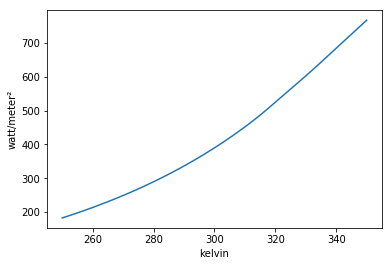

In [3]:
OLR = diagnostics['upwelling_longwave_flux_in_air_assuming_clear_sky']
olr_toa = OLR.sel(interface_levels=30).values[0] * units('W/m^2')
plt.plot(T_surf, olr_toa)

In [4]:
N = 25

p = pressures[0]
T = np.zeros((N, len(p))) * units('K')

T[:, 0] = np.linspace(250, 350, N) * units('K')

print('Calculating moist adiabats...')
for i in range(N):
    if i%10 == 0: print(i)
    T[i, :] = mpcalc.moist_lapse(temperature=T[i, 0], pressure=p)
print('done')

Calculating moist adiabats...
0
10
20
done


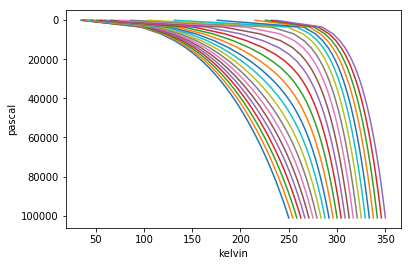

In [5]:
for i in range(N):
    plt.plot(T[i,:], p)
plt.gca().invert_yaxis()

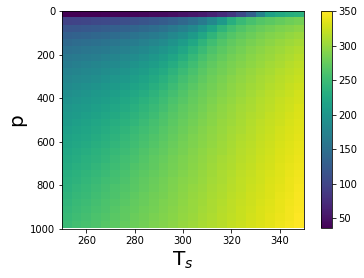

In [6]:
plt.imshow(T.T, origin='lower', #interpolation='hermite'
          extent=(250,350,1000,0), aspect=0.09)
plt.xlabel('T$_s$', size=20)
plt.ylabel('p', size=20)
plt.colorbar()

In [7]:
x = T[:, 0]
y = p
z = T.T

f = interp2d(x, y, z)

In [8]:
# plt.plot(f(300, p))
# plt.gca().invert_yaxis()

i = 12
interpT = f(x[i], p) * units('K')
interpT = np.flip(interpT, 0)
Ti = np.reshape(T[i, :], (30,1))

print(np.max(np.abs(Ti - interpT)))

0.0 kelvin


In [9]:
Tsurf = (305 - 35/90*np.abs(lats))
pres = p.magnitude

print(f(Tsurf, pres)[:,0])

[  38.65778656  107.05482745  129.9642295   145.7225      158.09374614
  168.42853744  177.38288571  185.32983187  192.50320434  199.05935968
  205.10753408  210.72634376  215.97347946  220.89184841  225.51372725
  229.86376526  233.96125123  237.82187232  241.45906788  244.88501134
  248.11128385  251.14926073  254.01026853  256.70559988  259.24642859
  261.64368001  263.90789903  266.04914055  268.07688903  270.        ]


In [155]:
# lats = np.arange(-90, 90, 0.5)

""" FULL BLOWN """
radiation = climt.RRTMGLongwave(cloud_overlap_method='clear_only')
state = climt.get_default_state([radiation], x={}, 
                y={'label' : 'latitude', 'values': lats, 'units' : 'degress N'},
                mid_levels={'label' : 'mid_levels', 'values': np.arange(30), 'units' : ''},
                interface_levels={'label' : 'interface_levels', 'values': np.arange(31), 'units' : ''}
                )

# samples = 100
# pressures = state['air_pressure'].values[0, 0, :] * units('Pa')
# Tsample = np.linspace(250, 350, samples) * units('K')
# Tdata = np.zeros((samples, len(pressures))) * units('K')
# Tdata[:, 0] = Tsample

# print('Calculating moist adiabats...')
# for i in range(samples):
#     if i%10 == 0: print(i)
#     Tdata[i, :] = mpcalc.moist_lapse(temperature=Tdata[i, 0], pressure=pressures)
# print('done')

# interpolated_moist_adiabat_f = interp2d(pressures, Tsample, Tdata)

def L(T):
    state['surface_temperature'].values[:] = T
    Tvals = np.zeros(state['air_temperature'].values[0].shape) * units('K')
    for i in range(len(lats)):
        state['air_temperature'].values[0, i, :] = np.flip(interpolated_moist_adiabat_f(pressures, T[i]), axis=0)
    tendencies, diagnostics = radiation(state)
    return diagnostics['upwelling_longwave_flux_in_air_assuming_clear_sky'].sel(interface_levels=30).values[0]

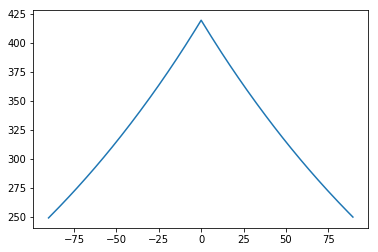

In [156]:
T = (305 - 35/90*np.abs(lats))
OLR = L(T)
plt.plot(lats, OLR)

In [159]:
state['surface_longwave_emissivity']

<xarray.DataArray (longitude: 1, latitude: 360, num_longwave_bands: 16)>
array([[[ 1.,  1., ...,  1.,  1.],
        [ 1.,  1., ...,  1.,  1.],
        ..., 
        [ 1.,  1., ...,  1.,  1.],
        [ 1.,  1., ...,  1.,  1.]]])
Coordinates:
  * longitude           (longitude) float64 0.0
  * latitude            (latitude) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ...
  * num_longwave_bands  (num_longwave_bands) int64 0 1 2 3 4 5 6 7 8 9 10 11 ...
Attributes:
    units:    dimensionless

In [4]:
for i in state.keys():
    print(i)

air_temperature
mole_fraction_of_oxygen_in_air
surface_temperature
mole_fraction_of_cfc11_in_air
x
aerosol_asymmetry_parameter
air_pressure
shortwave_optical_thickness_due_to_cloud
y
mole_fraction_of_methane_in_air
mole_fraction_of_ozone_in_air
mass_content_of_cloud_ice_in_atmosphere_layer
air_pressure_on_interface_levels
mid_levels
cloud_asymmetry_parameter
scalar
longwave_optical_thickness_due_to_cloud
mole_fraction_of_carbon_dioxide_in_air
surface_albedo_for_direct_near_infrared
surface_albedo_for_diffuse_shortwave
cloud_forward_scattering_fraction
cloud_ice_particle_size
cloud_area_fraction_in_atmosphere_layer
aerosol_optical_depth_at_55_micron
latitude
mole_fraction_of_nitrous_oxide_in_air
num_longwave_bands
zenith_angle
time
mole_fraction_of_cfc12_in_air
single_scattering_albedo_due_to_cloud
specific_humidity
surface_albedo_for_direct_shortwave
shortwave_optical_thickness_due_to_aerosol
num_ecmwf_aerosols
single_scattering_albedo_due_to_aerosol
interface_levels
solar_cycle_fracti

# Shortwave Radiation

In [2]:
def humidsat(t, p):
        """
        FROM BOOS:
        % function [esat,qsat,rsat]=_humidsat(t,p)
        %  computes saturation vapor pressure (esat), saturation specific humidity (qsat),
        %  and saturation mixing ratio (rsat) given inputs temperature (t) in K and
        %  pressure (p) in hPa.
        %
        %  these are all computed using the modified Tetens-like formulae given by
        %  Buck (1981, J. Appl. Meteorol.)
        %  for vapor pressure over liquid water at temperatures over 0 C, and for
        %  vapor pressure over ice at temperatures below -23 C, and a quadratic
        %  polynomial interpolation for intermediate temperatures.
        """
        tc=t-273.16;
        tice=-23;
        t0=0;
        Rd=287.04;
        Rv=461.5;
        epsilon=Rd/Rv;
    
        # first compute saturation vapor pressure over water
        ewat=(1.0007+(3.46e-6*p))*6.1121*np.exp(17.502*tc/(240.97+tc))
        eice=(1.0003+(4.18e-6*p))*6.1115*np.exp(22.452*tc/(272.55+tc))
        # alternatively don't use enhancement factor for non-ideal gas correction
        #ewat=6.1121.*exp(17.502.*tc./(240.97+tc));
        #eice=6.1115.*exp(22.452.*tc./(272.55+tc));
        eint=eice+(ewat-eice)*((tc-tice)/(t0-tice))**2
    
        esat=eint
        esat[np.where(tc<tice)]=eice[np.where(tc<tice)]
        esat[np.where(tc>t0)]=ewat[np.where(tc>t0)]
    
        # now convert vapor pressure to specific humidity and mixing ratio
        rsat=epsilon*esat/(p-esat);
        qsat=epsilon*esat/(p-esat*(1-epsilon));
        return esat, qsat, rsat


In [3]:
RH = 0.8

longwave_radiation = climt.RRTMGLongwave(cloud_overlap_method='clear_only')
shortwave_radiation = climt.RRTMGShortwave(cloud_overlap_method='clear_only', ignore_day_of_year=True)

N_pts = 401
nLevels = 30
dx = 2 / N_pts
sin_lats = np.linspace(-1 + dx/2, 1 - dx/2, N_pts)
lats = np.arcsin(sin_lats)

grid = climt.get_grid(nx=1, ny=N_pts, nz=nLevels)
grid["latitude"].values[:] = np.rad2deg(lats).reshape((N_pts, 1))
state = climt.get_default_state([shortwave_radiation, longwave_radiation], grid_state=grid)
state["zenith_angle"].values[:] = lats.reshape((N_pts, 1))

low = 270
high = 305
T = 2/3*high + 1/3*low - 2/3 * (high-low) * 1/2 * (3 * sin_lats**2 - 1)
state['surface_temperature'].values[:] = T.reshape((N_pts, 1))
pressures = state['air_pressure'].values[:, 0, 0]

# Create the 2d interpolation function: gives function T_moist(T_surf, p)
moist_data = np.load('data/moist_adiabat_data.npz')
# pressures  = moist_data['pressures']
Tsample    = moist_data['Tsample']
Tdata      = moist_data['Tdata']
# RectBivariateSpline needs increasing x values
pressures_flipped = np.flip(pressures, axis=0)
Tdata = np.flip(Tdata, axis=1)
interpolated_moist_adiabat = RectBivariateSpline(Tsample, pressures_flipped, Tdata)                    

Tgrid = np.repeat(T, nLevels).reshape( (N_pts, nLevels) )
state['air_temperature'].values[:, :, 0] = interpolated_moist_adiabat.ev(Tgrid, pressures).T

# Vertical RH profile
RH_dist = RH * np.ones( (N_pts, nLevels) )
for i in range(nLevels):
    # 0-200:    0
    # 200-300:  0.8
    # 300-800:  0.2
    # 800-1000: 0.8
    if pressures[i]/100 < 200:
        RH_dist[:, i] = 0
    elif pressures[i]/100 > 300 and pressures[i]/100 < 800:
        RH_dist[:, i] = 0.2

# Latitudinal RH profile
gaussian = lambda mu, sigma, lat: np.exp( -(lat - mu)**2 / (2 * sigma**2) )
spread = np.deg2rad(5)
lat_efe = 0
midlevels = np.where( np.logical_and(pressures/100 < 800, pressures/100 > 300) )[0]
def shift_dist(RH_dist, lat_center):
    RH_dist[:, midlevels] =  np.repeat(0.2 + (RH-0.2) * gaussian(lat_center, spread, lats), len(midlevels)).reshape( (N_pts, len(midlevels)) )
    return RH_dist
RH_dist = shift_dist(RH_dist, lat_efe)

# specific humidity
state['specific_humidity'].values[:, :, 0] = RH_dist.T * humidsat(state['air_temperature'].values[:, :, 0], state['air_pressure'].values[:, :, 0] / 100)[1]

alb = 0.2725
# alb = 0.06
alb = 0.06
state['surface_albedo_for_diffuse_near_infrared'].values[:] = alb
state['surface_albedo_for_direct_near_infrared'].values[:] = alb
state['surface_albedo_for_diffuse_shortwave'].values[:] = alb
state['surface_albedo_for_direct_shortwave'].values[:] = alb

longwave_tendencies, longwave_diagnostics = longwave_radiation(state)
shortwave_tendencies, shortwave_diagnostics = shortwave_radiation(state)

print("done.")

done.


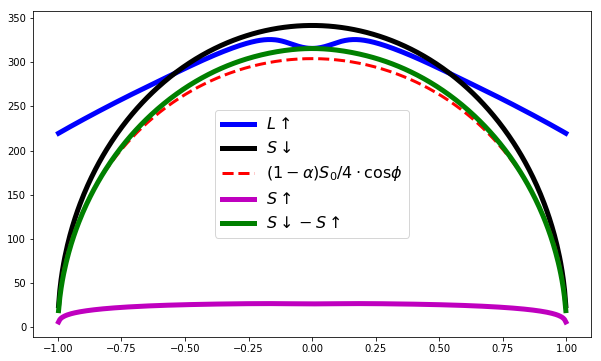

In [14]:
f, ax = plt.subplots(1, figsize=(10,6))

ax.plot(sin_lats, 
        longwave_diagnostics['upwelling_longwave_flux_in_air_assuming_clear_sky'].values[-1, :, 0], 
        'b-', lw=5, label="$L \\uparrow$")
ax.plot(sin_lats, 
        0.25 * shortwave_diagnostics['downwelling_shortwave_flux_in_air_assuming_clear_sky'].values[-1, :, 0], 
        'k-', lw=5, label="$S \\downarrow$")
ax.plot(sin_lats, (1-0.11) * 1367 / 4 * np.cos(lats), 
        'r--', lw=3, label="$(1-\\alpha)S_0 / 4 \\cdot \\cos\\phi$")
ax.plot(sin_lats, 
        0.25 * shortwave_diagnostics['upwelling_shortwave_flux_in_air_assuming_clear_sky'].values[-1, :, 0], 
        'm-', lw=5, label="$S \\uparrow$")
ax.plot(sin_lats, 
        0.25 * shortwave_diagnostics['downwelling_shortwave_flux_in_air_assuming_clear_sky'].values[-1, :, 0] 
        - 0.25 * shortwave_diagnostics['upwelling_shortwave_flux_in_air_assuming_clear_sky'].values[-1, :, 0], 
        'g-', lw=5, label="$S \\downarrow - S \\uparrow$")
ax.legend(fontsize=16)

In [15]:
print(shortwave_diagnostics['downwelling_shortwave_flux_in_air_assuming_clear_sky'].values[-1, :, 0])


shortwave_diagnostics['downwelling_shortwave_flux_in_air_assuming_clear_sky'].values[-1, :, 0] = 5000

longwave_tendencies, longwave_diagnostics = longwave_radiation(state)
shortwave_tendencies, shortwave_diagnostics = shortwave_radiation(state)

print(shortwave_diagnostics['downwelling_shortwave_flux_in_air_assuming_clear_sky'].values[-1, :, 0])


[  96.48050153  166.90037439  215.19761624  254.30557284  287.99247559
  317.98590991  345.24982708  370.38747088  393.80622821  415.79663715
  436.57459027  456.30574573  475.12053799  493.12386936  510.4016147
  527.02513946  543.05452627  558.54093038  573.52833829  588.0549041
  602.15398124  615.85493053  629.18376111  642.16364448  654.8153316
  667.15749421  679.20700602  690.97917721  702.48795078  713.74606828
  724.76521047  735.55611748  746.12869194  756.49208802  766.65478858
  776.6246724   786.40907295  796.01482999  805.44833503  814.71557157
  823.82215072  832.77334297  841.57410665  850.22911294  858.74276835
  867.11923698  875.36245713  883.4761586   891.46387786  899.32897179
  907.07463019  914.70388718  922.21963163  929.62461669  936.92146854
  944.11269441  951.20068994  958.187746    965.07605499  971.86771658
  978.5647431   985.16906518  991.6825343   998.10692929 1004.44395966
 1010.69526823 1016.86243597 1022.94698467 1028.95038002 1034.87403435
 1040.719

In [6]:
from sympl import get_constant
get_constant('stellar_irradiance', 'W/m^2')

1367.0

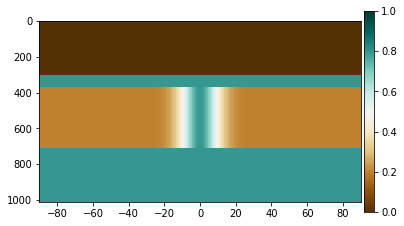

[1010.63266447 1002.92013389  990.10482179  972.31847063  949.74392553
  922.61325466  891.20536351  855.84312775  816.89007399  774.74664273
  729.84607179  682.64994254  633.64343482  583.33033921  532.227878
  480.86138803  429.75892013  379.44581057  330.43928038  283.24311796
  238.34249955  196.19900056  157.24584869  121.88346633   90.47534529
   63.34428722   40.76901621   22.98104754   10.16073333    2.4021306 ]
[1011.1736      976.34048276  941.50736552  906.67424828  871.84113103
  837.00801379  802.17489655  767.34177931  732.50866207  697.67554483
  662.84242759  628.00931034  593.1761931   558.34307586  523.50995862
  488.67684138  453.84372414  419.0106069   384.17748966  349.34437241
  314.51125517  279.67813793  244.84502069  210.01190345  175.17878621
  140.34566897  105.51255172   70.67943448   35.84631724    1.0132    ]


In [7]:
state['specific_humidity']
plt.imshow(RH_dist.T, extent=(-90, 90, pressures[0]/100, 0), origin='lower', aspect=.1, cmap='BrBG', vmin=0.0, vmax=1.0)
plt.colorbar(pad=0.01,fraction=0.03)
plt.show()

print(pressures/100)
print(moist_data["pressures"]/100)

In [16]:
climt.__version__

'0.16.0'